# Rare Event Binary Classification using Autoencoder

Here we will show an implementation of building a binary classifier using Autoencoders. The purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [213]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

## Reading and preparing data

In [214]:
df = pd.read_csv("data/processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [215]:
# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df.loc[df['y'] == 1].head(n=5)  # y = 1 rows before the shift
df.y = df.y.shift(-2)
df = df.dropna(axis = 0)
df.loc[df['y'] == 1].head(n=5)  # Validating if the shift happened correctly.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
257,5/1/99 8:34,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,...,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695,0
774,5/2/99 3:58,1.0,-0.738480,-4.604522,5.133959,-322.781610,-0.485865,23.919441,0.030640,-0.081257,...,0.381027,-5.308781,2.682929,-54.851986,-38.804999,1.031932,0.014034,4.182024,0.007835,0
833,5/2/99 6:20,1.0,-0.629733,-1.964926,4.587883,117.531806,-0.577403,-8.266746,0.070619,0.008773,...,-1.628738,-6.339299,2.572946,-26.438168,-67.357718,-0.219349,0.015600,3.994639,0.007759,0
1034,5/2/99 13:04,1.0,-0.782326,-0.006451,-0.994674,172.844061,-0.079173,11.676155,0.010803,0.028915,...,-2.757156,-6.856144,2.704050,-38.737118,-52.677802,-0.860218,0.020183,3.017946,0.006259,0
1261,5/2/99 20:38,1.0,-1.170825,-2.334464,0.811321,21.784553,-0.825221,8.194161,-0.069155,0.028915,...,-2.757156,-6.856144,2.761333,6.508243,-48.431540,0.085826,0.036405,3.578516,0.005116,0


In [216]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

### Divide the data into train, valid, and test

In [217]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which `y=0` and build an autoencoder. For that, we will divide the datasets as following.

In [219]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

In [221]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

## Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [222]:
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [223]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 11692 samples, validate on 2921 samples
Epoch 1/100
11692/11692 [==============================] - 1s 92us/step - loss: 2.7571 - acc: 0.0618 - val_loss: 2.2512 - val_acc: 0.0986
Epoch 2/100
11692/11692 [==============================] - 0s 22us/step - loss: 1.9198 - acc: 0.1140 - val_loss: 1.5977 - val_acc: 0.1092
Epoch 3/100
11692/11692 [==============================] - 0s 22us/step - loss: 1.4037 - acc: 0.1189 - val_loss: 1.2392 - val_acc: 0.1321
Epoch 4/100
11692/11692 [==============================] - 0s 21us/step - loss: 1.1520 - acc: 0.1245 - val_loss: 1.0701 - val_acc: 0.1198
Epoch 5/100
11692/11692 [==============================] - 0s 21us/step - loss: 1.0275 - acc: 0.1345 - val_loss: 0.9812 - val_acc: 0.1462
Epoch 6/100
11692/11692 [==============================] - 0s 23us/step - loss: 0.9575 - acc: 0.1582 - val_loss: 0.9269 - val_acc: 0.1732
Epoch 7/100
11692/11692 [==============================] - 0s 21us/step - loss: 0.9129 - acc: 0.1767 - val_loss: 0.8921 - v

11692/11692 [==============================] - 0s 19us/step - loss: 0.6895 - acc: 0.4912 - val_loss: 0.6787 - val_acc: 0.5002
Epoch 60/100
11692/11692 [==============================] - 0s 19us/step - loss: 0.6867 - acc: 0.4940 - val_loss: 0.6719 - val_acc: 0.4937
Epoch 61/100
11692/11692 [==============================] - 0s 19us/step - loss: 0.6834 - acc: 0.5000 - val_loss: 0.6699 - val_acc: 0.5012
Epoch 62/100
11692/11692 [==============================] - 0s 20us/step - loss: 0.6829 - acc: 0.5028 - val_loss: 0.6734 - val_acc: 0.5043
Epoch 63/100
11692/11692 [==============================] - 0s 19us/step - loss: 0.6815 - acc: 0.5027 - val_loss: 0.6685 - val_acc: 0.4868
Epoch 64/100
11692/11692 [==============================] - 0s 19us/step - loss: 0.6806 - acc: 0.4983 - val_loss: 0.6688 - val_acc: 0.4793
Epoch 65/100
11692/11692 [==============================] - 0s 19us/step - loss: 0.6795 - acc: 0.4969 - val_loss: 0.6709 - val_acc: 0.4700
Epoch 66/100
11692/11692 [==============

In [224]:
autoencoder = load_model('autoencoder_classifier.h5')

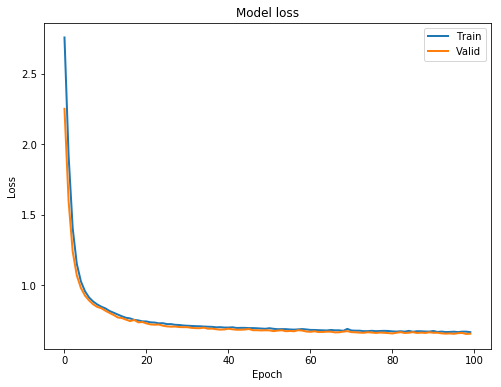

In [225]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [226]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})

error_df.describe()

,Reconstruction_error,True_class
count,3680.000000,3680.000000
mean,0.610864,0.005707
std,1.466895,0.075336
min,0.130869,0.000000
25%,0.320530,0.000000
50%,0.418696,0.000000
75%,0.548713,0.000000
max,32.643743,1.000000


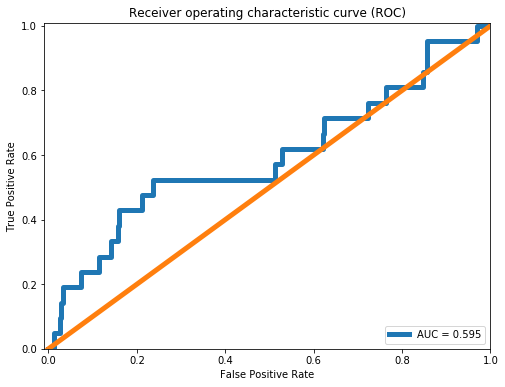

In [227]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

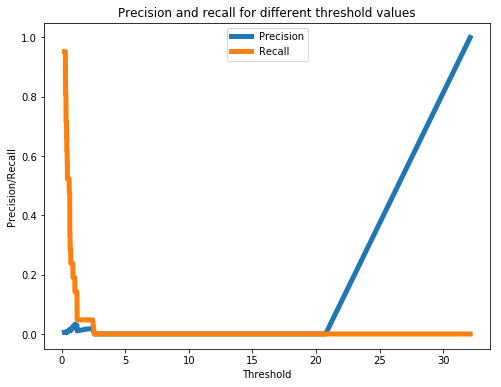

In [232]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

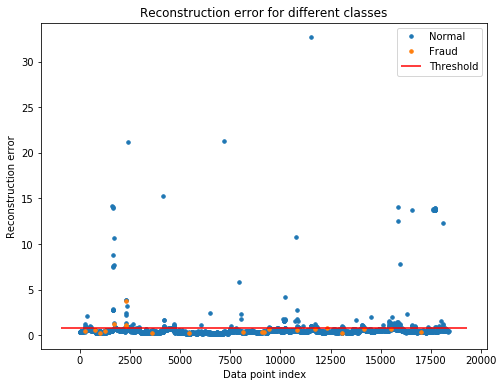

In [229]:
threshold_fixed = 0.8
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [230]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]


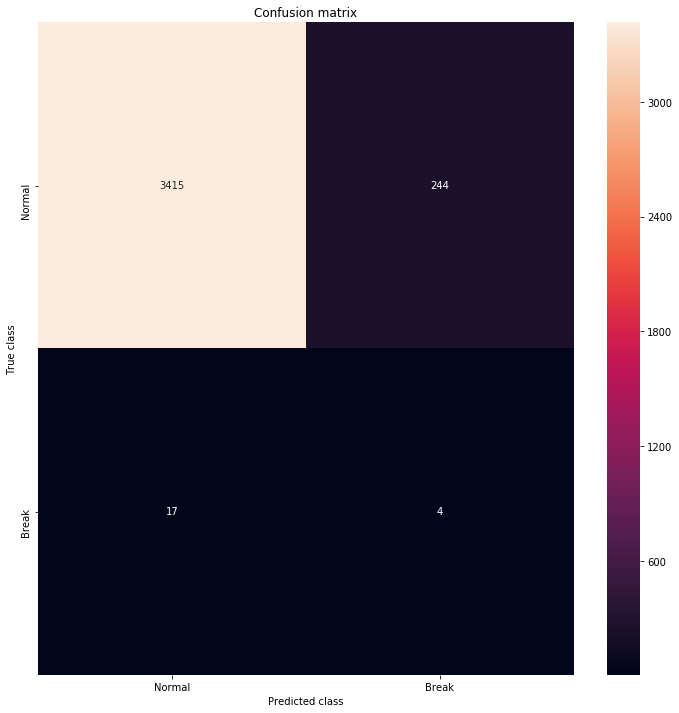

In [231]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()